<h1><center>Two Factor Anova</center></h1>

### Data

In [1]:
data("warpbreaks")
?warpbreaks
head(warpbreaks)

breaks,wool,tension
26,A,L
30,A,L
54,A,L
25,A,L
70,A,L
52,A,L


In [2]:
table(warpbreaks$wool, warpbreaks$tension)

   
    L M H
  A 9 9 9
  B 9 9 9

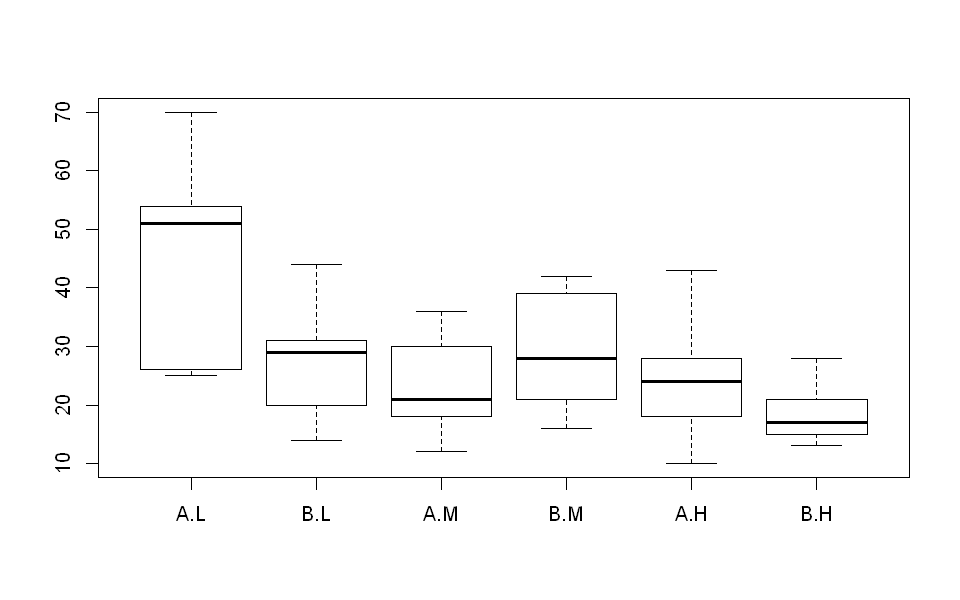

In [3]:
options(repr.plot.width=8, repr.plot.height=5)

boxplot(breaks ~ wool + tension, data=warpbreaks)

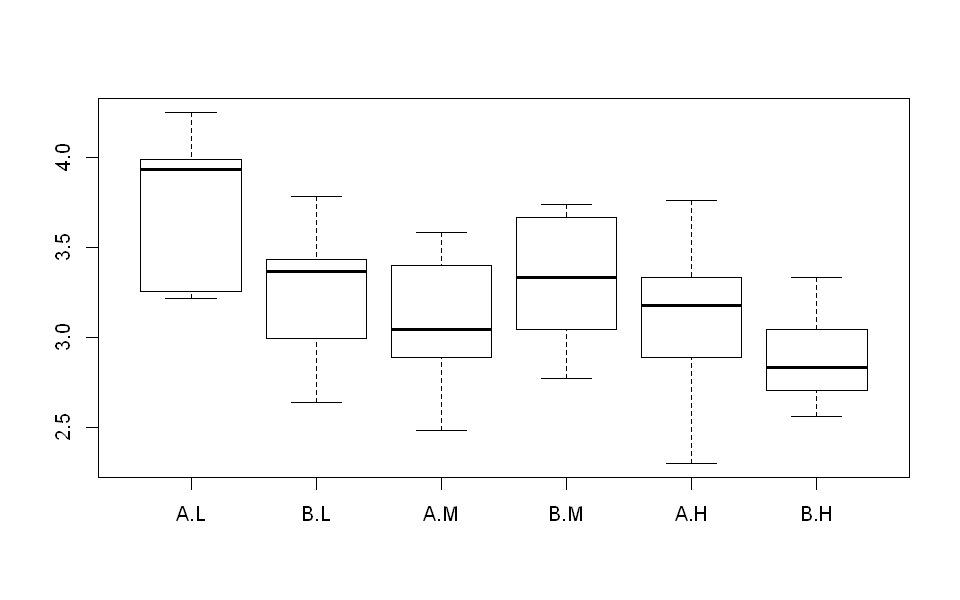

In [4]:
boxplot(log(breaks) ~ wool + tension, data=warpbreaks)

# The different groups have more similar variance if we use the logarithm of breaks. 
# From this visualization, it looks like both factors may play a role in the number of breaks. 
# It appears that there is a general decrease in breaks as we move from low to medium to high tension.

# One-way model

In [5]:
library("coda")
library("rjags")

Warning message:
"package 'coda' was built under R version 3.4.4"Warning message:
"package 'rjags' was built under R version 3.4.4"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [6]:
set.seed(83)

### Modelling

In [7]:
mod_1_str = " model {
    # Actual Bayesian Model Likelihood
    for(i in 1:length(y)){
        y[i] ~ dnorm(mu[tensGrp[i]], prec)
    }

    # Priors
    for (j in 1:3){
        mu[j] ~ dnorm(0.0, 1.0/1.0e6)
    }
    prec ~ dgamma(5/2.0, 5*1.0/2.0)

    # Variable dependent on Priors
    sig = sqrt(1/prec)
} "

In [8]:
data_1_jags = list(y = log(warpbreaks$breaks), tensGrp = as.numeric(warpbreaks$tension))

In [9]:
params_1 = c("mu", "sig")

In [10]:
inits_1 = function(){
    inits = list(mu = rnorm(3, 1.0, 100.0), 
                 prec = rgamma(1, 1.0, 1.0))
}

In [11]:
mod1 = jags.model(textConnection(mod_1_str), 
                  inits = inits_1, 
                  data = data_1_jags, 
                  n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 54
   Unobserved stochastic nodes: 4
   Total graph size: 122

Initializing model



### Simulations

In [12]:
update(mod1, 1e3)

In [13]:
mod_1_sim = coda.samples(model = mod1, 
                         variable.names = params_1, 
                         n.iter = 1e4)

In [14]:
mod_1_csim = as.mcmc(do.call(rbind, mod_1_sim))

### Model Checking

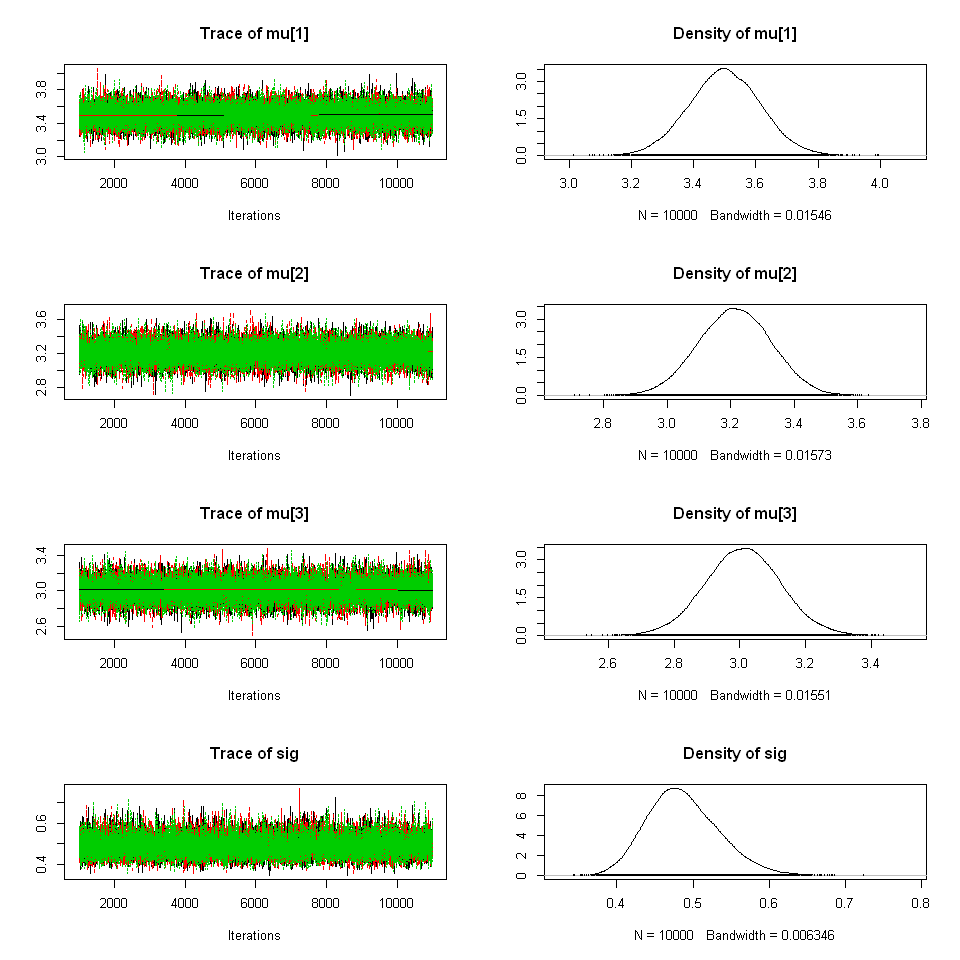

In [15]:
options(repr.plot.width=8, repr.plot.height=8)

plot(mod_1_sim)

In [16]:
gelman.diag(mod_1_sim)
autocorr.diag(mod_1_sim)
effectiveSize(mod_1_sim)

Potential scale reduction factors:

      Point est. Upper C.I.
mu[1]          1          1
mu[2]          1          1
mu[3]          1          1
sig            1          1

Multivariate psrf

1

,mu[1],mu[2],mu[3],sig
Lag 0,1.0000000000,1.000000000,1.0000000000,1.000000000
Lag 1,-0.0046419431,-0.003482691,0.0005520462,0.054913099
Lag 5,-0.0029803140,-0.003802679,-0.0043314043,0.004566056
Lag 10,0.0008100547,-0.007562383,-0.0017993661,0.002754587
Lag 50,0.0039595570,0.004107441,0.0016801729,-0.001910988


mu[1]    mu[2]    mu[3]      sig 
31421.87 30000.00 30000.00 26131.56

### Results

In [17]:
summary(mod_1_sim)

# The 95% posterior interval for the mean of group 2 (medium tension) overlaps with both the low and high groups,
# but the intervals for low and high group only slightly overlap. That is a pretty strong indication that the means
# for low and high tension are different.


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
mu[1] 3.5003 0.11577 0.0006684      0.0006543
mu[2] 3.2135 0.11660 0.0006732      0.0006732
mu[3] 3.0105 0.11594 0.0006694      0.0006694
sig   0.4875 0.04757 0.0002747      0.0002944

2. Quantiles for each variable:

        2.5%    25%    50%    75%  97.5%
mu[1] 3.2721 3.4237 3.5001 3.5773 3.7293
mu[2] 2.9843 3.1351 3.2139 3.2922 3.4405
mu[3] 2.7815 2.9334 3.0107 3.0875 3.2417
sig   0.4046 0.4543 0.4836 0.5173 0.5903


In [18]:
dic_1 = dic.samples(mod1, 1e4)
dic_1

Mean deviance:  58.47 
penalty 4.015 
Penalized deviance: 62.48 

# Two-way Additive Model

We will fit the additive model which treats the two factors separately with no interaction.

In [19]:
# Design Matrix

X = model.matrix(breaks ~ wool + tension, data=warpbreaks)
head(X)

(Intercept),woolB,tensionM,tensionH
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0


In [20]:
# By default, R has chosen the mean for wool A and low tension to be the intercept. 
# Then, there is an effect for wool B, and effects for medium tension and high tension, 
# each associated with dummy indicator variables.

### Modelling

In [21]:
mod_2_str = " model {
    # Actual Bayesian Model Likelihood
    for(i in 1:length(y)){
        y[i] ~ dnorm(mu[i], prec)
        mu[i] = int + alpha*isWoolB[i] + beta[1]*isTensionM[i] + beta[2]*isTensionH[i]
    }

    # Priors
    for (j in 1:2){
        beta[j] ~ dnorm(0.0, 1.0/1.0e6)
    }
    int ~ dnorm(0.0, 1.0/1.0e6)
    alpha ~ dnorm(0.0, 1.0/1.0e6)
    prec ~ dgamma(3/2.0, 3*1.0/2.0)

    # Variable dependent on Priors
    sig = sqrt(1/prec)
} "

In [22]:
data_2_jags = list(y = log(warpbreaks$breaks), 
                   isWoolB = X[,"woolB"], 
                   isTensionM = X[,"tensionM"], 
                   isTensionH = X[,"tensionH"])

In [23]:
params_2 = c("int", "alpha", "beta", "sig")

In [24]:
inits_2 = function(){
    inits = list(int = rnorm(1, 1.0, 100.0), 
                 alpha = rnorm(1, 1.0, 100.0), 
                 beta = rnorm(2, 1.0, 100.0),
                 prec = rgamma(1, 1.0, 1.0))
}

In [25]:
mod2 = jags.model(textConnection(mod_2_str), 
                  inits = inits_2, 
                  data = data_2_jags, 
                  n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 54
   Unobserved stochastic nodes: 5
   Total graph size: 243

Initializing model



### Simulations

In [26]:
update(mod2, 1e3)

In [27]:
mod_2_sim = coda.samples(model = mod2, 
                         variable.names = params_2, 
                         n.iter = 1e4)

In [28]:
mod_2_csim = as.mcmc(do.call(rbind, mod_2_sim))

### Model Checking

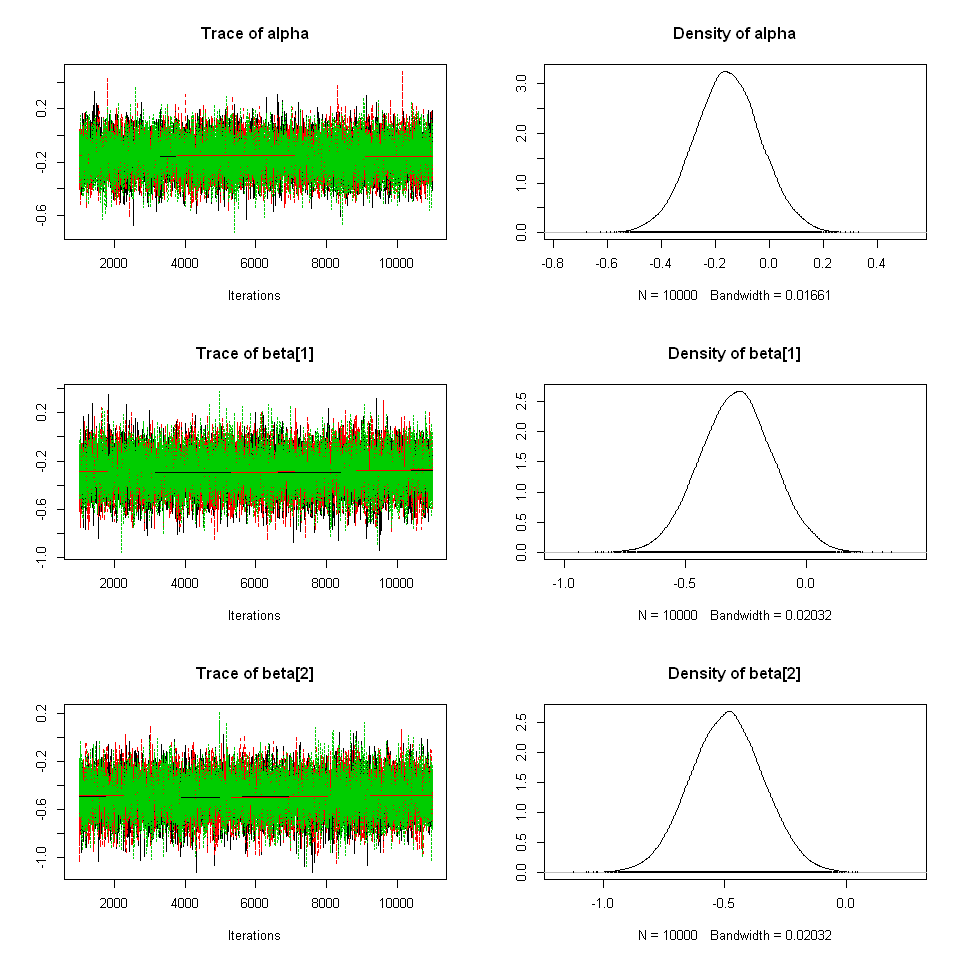

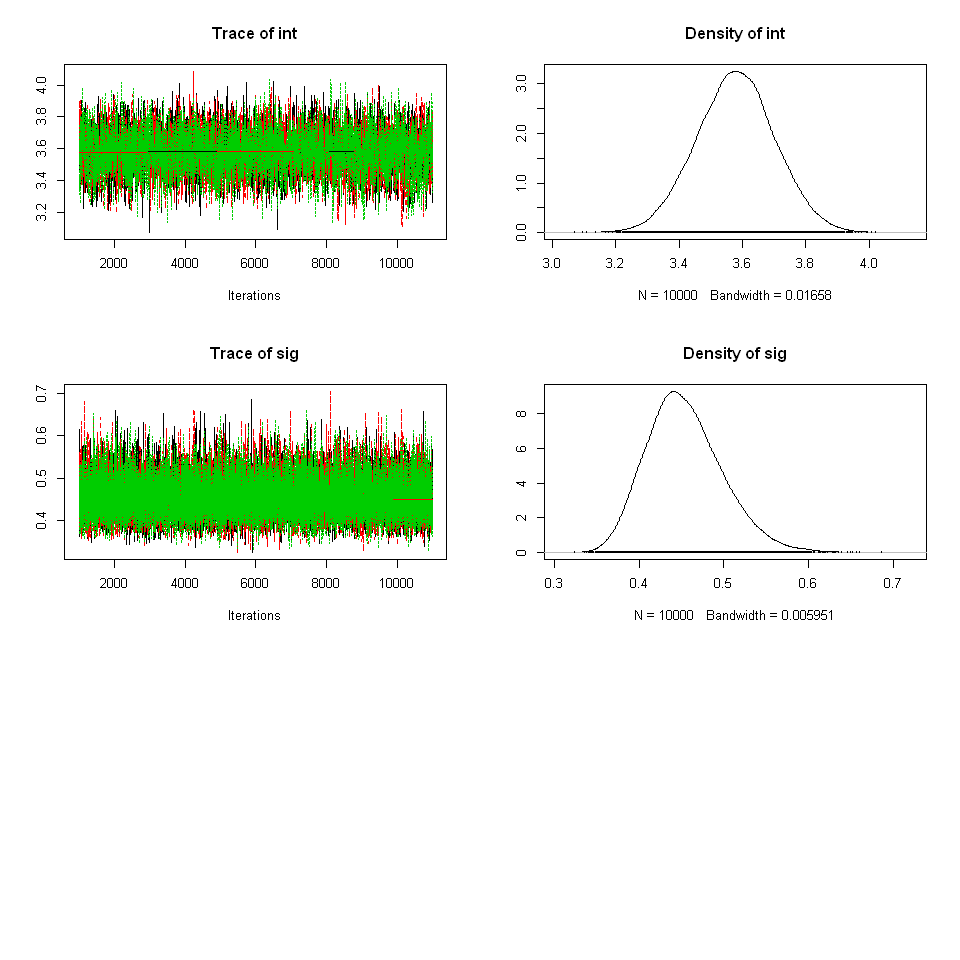

In [29]:
plot(mod_2_sim)

In [30]:
gelman.diag(mod_2_sim)
autocorr.diag(mod_2_sim)
effectiveSize(mod_2_sim)

Potential scale reduction factors:

        Point est. Upper C.I.
alpha            1          1
beta[1]          1          1
beta[2]          1          1
int              1          1
sig              1          1

Multivariate psrf

1

,alpha,beta[1],beta[2],int,sig
Lag 0,1.000000000,1.000000000,1.000000e+00,1.000000000,1.0000000000
Lag 1,0.505538909,0.499410356,4.978099e-01,0.749521315,0.0602400522
Lag 5,0.037533453,0.096193312,9.549920e-02,0.178039198,-0.0039137146
Lag 10,-0.008099479,0.000867951,3.014521e-05,0.016586649,-0.0123343144
Lag 50,0.001091653,0.009228091,5.878480e-03,0.004510366,-0.0005007367


alpha   beta[1]   beta[2]       int       sig 
 9851.864  7649.165  7686.091  4879.490 25858.623

### Results

In [31]:
summary(mod_2_sim)


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD  Naive SE Time-series SE
alpha   -0.1540 0.1243 0.0007179      0.0012527
beta[1] -0.2875 0.1517 0.0008761      0.0017365
beta[2] -0.4911 0.1511 0.0008726      0.0017252
int      3.5787 0.1239 0.0007154      0.0017783
sig      0.4542 0.0451 0.0002604      0.0002805

2. Quantiles for each variable:

           2.5%     25%     50%      75%    97.5%
alpha   -0.3992 -0.2366 -0.1544 -0.07153  0.09291
beta[1] -0.5840 -0.3889 -0.2873 -0.18698  0.01240
beta[2] -0.7851 -0.5925 -0.4908 -0.39058 -0.19511
int      3.3341  3.4958  3.5796  3.66047  3.82104
sig      0.3770  0.4227  0.4503  0.48179  0.55243


In [32]:
dic_2 = dic.samples(mod2, 1e4)
dic_2

Mean deviance:  55.5 
penalty 5.11 
Penalized deviance: 60.61 

In [33]:
# Comapre it with DIC of model 1

dic_1

Mean deviance:  58.47 
penalty 4.015 
Penalized deviance: 62.48 

In [34]:
# This suggests there is much to be gained adding the wool factor to the model. 
# Before we settle on this model however, we should consider whether there is an interaction. 
# Let’s look again at the box plot with all six treatment groups

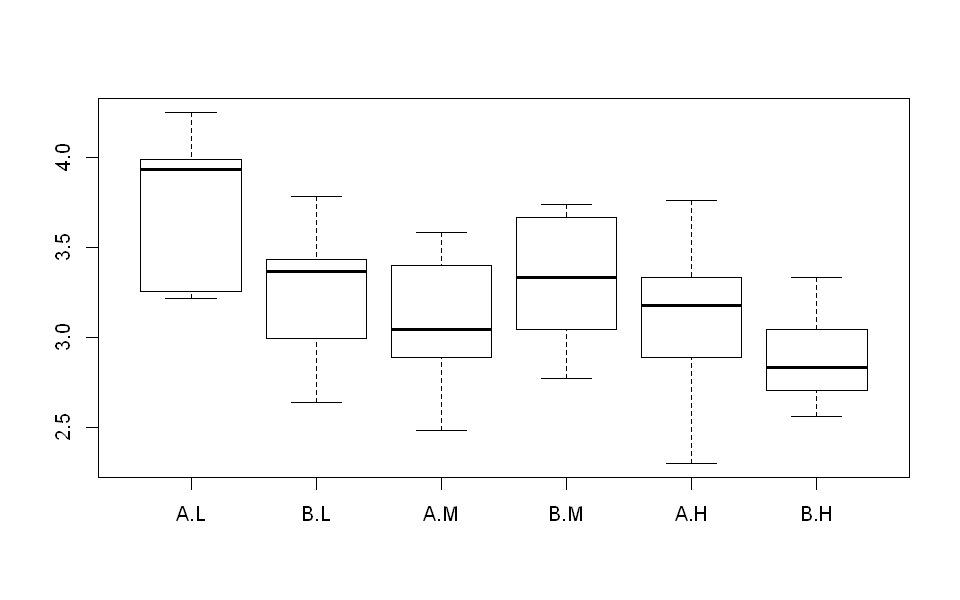

In [35]:
options(repr.plot.width=8, repr.plot.height=5)

boxplot(log(breaks) ~ wool + tension, data=warpbreaks)

In [36]:
# This two-way model has a single effect for wool B and the estimate is negative. 
# If this is true, then we would expect wool B to be associated with fewer breaks than its wool A counterpart on average.
# This is true for low and high tension, but it appears that breaks are higher for wool B when there is medium tension.
# That is, the effect for wool B is not consistent across tension levels, so it may appropriate to add an interaction term.

In [37]:
# Similar Model can be created in R.

lmod2 = lm(log(breaks) ~ .^2, data=warpbreaks)
summary(lmod2)


Call:
lm(formula = log(breaks) ~ .^2, data = warpbreaks)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.81504 -0.27885  0.04042  0.27319  0.64358 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.7179     0.1247  29.824  < 2e-16 ***
woolB           -0.4356     0.1763  -2.471  0.01709 *  
tensionM        -0.6012     0.1763  -3.410  0.00133 ** 
tensionH        -0.6003     0.1763  -3.405  0.00134 ** 
woolB:tensionM   0.6281     0.2493   2.519  0.01514 *  
woolB:tensionH   0.2221     0.2493   0.891  0.37749    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.374 on 48 degrees of freedom
Multiple R-squared:  0.3363,	Adjusted R-squared:  0.2672 
F-statistic: 4.864 on 5 and 48 DF,  p-value: 0.001116


In [38]:
# Adding the interaction, we get an effect for being in wool B and medium tension, as well as for being in wool B 
# and high tension. There are now six parameters for the mean, one for each treatment group, so this model is 
# equivalent to the full cell means model.

# Two-way cell means model

In this new model, μ will be a matrix with six entries, each corresponding to a treatment group.

In [39]:
mod_3_str = " model {
    # Actual Bayesian Model Likelihood
    for(i in 1:length(y)){
        y[i] ~ dnorm(mu[woolGrp[i], tensGrp[i]], prec)
    }

    # Priors
    for (j in 1:max(woolGrp)){
        for (k in 1:max(tensGrp)){
            mu[j, k] ~ dnorm(0.0, 1.0/1.0e6)
    }}
    prec ~ dgamma(3/2.0, 3*1.0/2.0)

    # Variable dependent on Priors
    sig = sqrt(1/prec)
} "

In [40]:
data_3_jags = list(y = log(warpbreaks$breaks), 
                   woolGrp = as.numeric(warpbreaks$wool), 
                   tensGrp = as.numeric(warpbreaks$tension))

In [41]:
params_3 = c("mu", "sig")

In [42]:
inits_3 = function(){
    inits = list(mu = matrix(rnorm(6, 1.0, 100.0), nrow = 2, byrow = TRUE),
                 prec = rgamma(1, 1.0, 1.0))
}

In [43]:
mod3 = jags.model(textConnection(mod_3_str), 
                  inits = inits_3, 
                  data = data_3_jags, 
                  n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 54
   Unobserved stochastic nodes: 7
   Total graph size: 179

Initializing model



### Simulations

In [44]:
update(mod3, 1e3)

In [45]:
mod_3_sim = coda.samples(model = mod3, 
                         variable.names = params_3, 
                         n.iter = 1e4)

In [46]:
mod_3_csim = as.mcmc(do.call(rbind, mod_3_sim))

### Model Checking

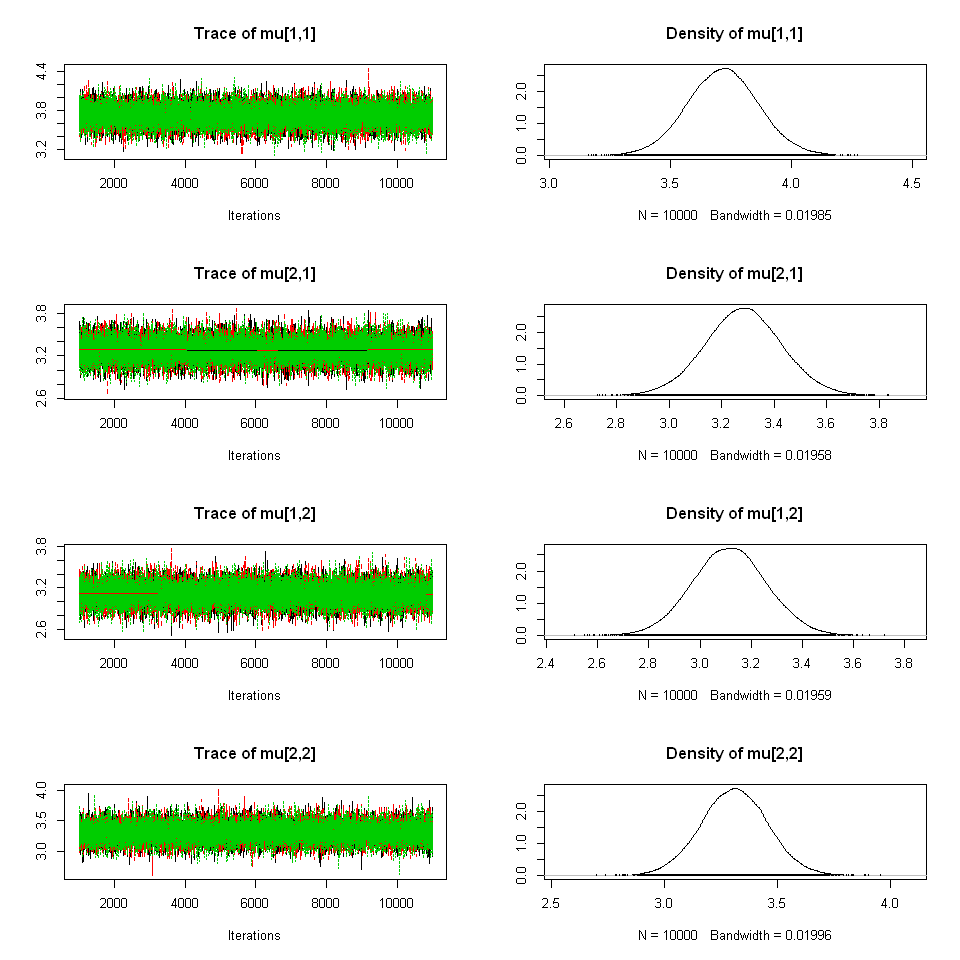

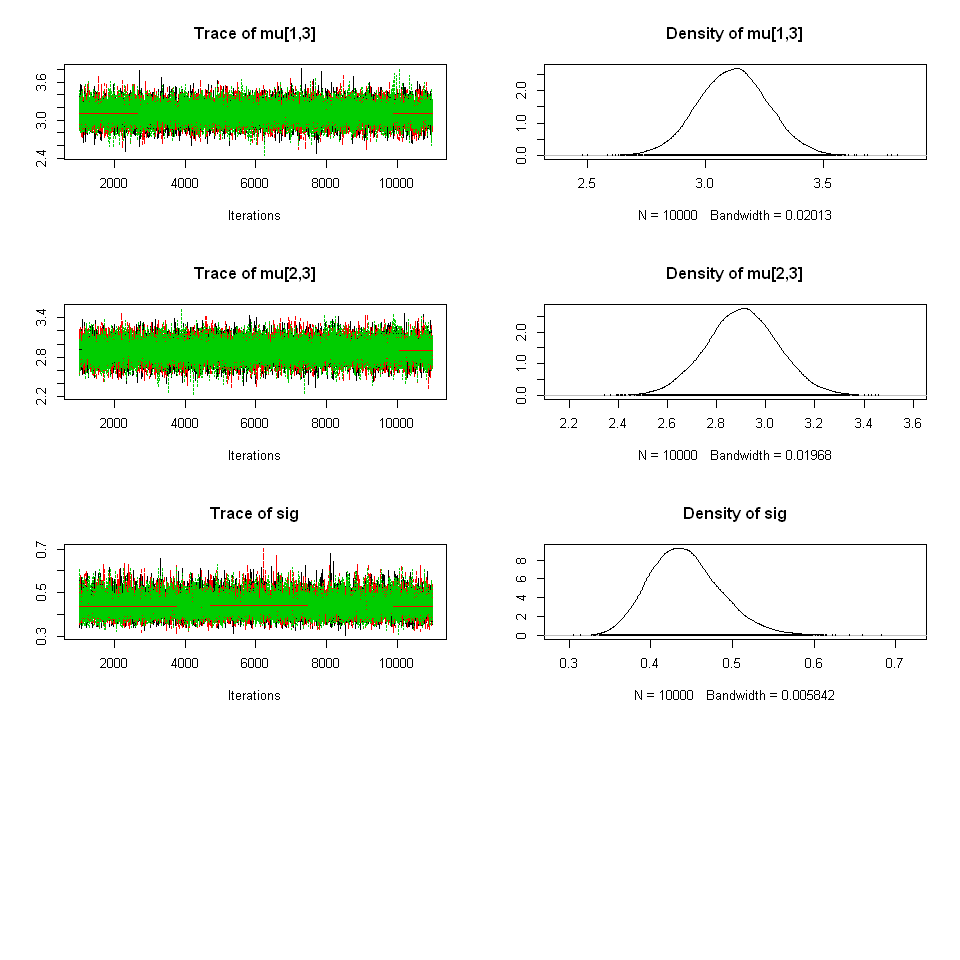

In [47]:
options(repr.plot.width=8, repr.plot.height=8)

plot(mod_3_sim)

In [48]:
gelman.diag(mod_3_sim)
autocorr.diag(mod_3_sim)
effectiveSize(mod_3_sim)
raftery.diag(mod_3_sim)

Potential scale reduction factors:

        Point est. Upper C.I.
mu[1,1]          1          1
mu[2,1]          1          1
mu[1,2]          1          1
mu[2,2]          1          1
mu[1,3]          1          1
mu[2,3]          1          1
sig              1          1

Multivariate psrf

1

,"mu[1,1]","mu[2,1]","mu[1,2]","mu[2,2]","mu[1,3]","mu[2,3]",sig
Lag 0,1.0000000000,1.000000000,1.000000000,1.0000000000,1.000000000,1.000000000,1.000000000
Lag 1,-0.0045437316,0.009177736,0.010241505,-0.0063383069,0.003281194,0.011849603,0.109829993
Lag 5,-0.0009115161,0.006036113,-0.010412210,-0.0042755771,-0.003732549,0.001828477,-0.002216899
Lag 10,0.0033176680,-0.003160836,0.003931382,-0.0005586588,0.003176643,0.002308493,0.007068770
Lag 50,-0.0063065550,0.005792260,0.004355028,0.0041035169,-0.010892135,-0.002963242,-0.001036989


mu[1,1]  mu[2,1]  mu[1,2]  mu[2,2]  mu[1,3]  mu[2,3]      sig 
31001.31 29059.64 29341.36 30510.26 30000.00 29274.43 24061.12

[[1]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                               
         Burn-in  Total Lower bound  Dependence
         (M)      (N)   (Nmin)       factor (I)
 mu[1,1] 2        3741  3746         0.999     
 mu[2,1] 2        3680  3746         0.982     
 mu[1,2] 2        3897  3746         1.040     
 mu[2,2] 2        3741  3746         0.999     
 mu[1,3] 2        3710  3746         0.990     
 mu[2,3] 2        3771  3746         1.010     
 sig     2        3802  3746         1.010     


[[2]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                               
         Burn-in  Total Lower bound  Dependence
         (M)      (N)   (Nmin)       factor (I)
 mu[1,1] 2        3680  3746         0.982     
 mu[2,1] 2        3771  3746         1.010     
 mu[1,2] 2        3865  3746         1.030     
 mu[2,2] 2        3741  3746         0.999     
 mu[1,3] 2        3741  3746

### Results

In [49]:
summary(mod_3_sim)


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean      SD  Naive SE Time-series SE
mu[1,1] 3.7171 0.14855 0.0008577      0.0008445
mu[2,1] 3.2831 0.14740 0.0008510      0.0008654
mu[1,2] 3.1162 0.14707 0.0008491      0.0008585
mu[2,2] 3.3094 0.14858 0.0008578      0.0008507
mu[1,3] 3.1182 0.14928 0.0008619      0.0008618
mu[2,3] 2.9044 0.14861 0.0008580      0.0008687
sig     0.4426 0.04431 0.0002558      0.0002856

2. Quantiles for each variable:

         2.5%    25%    50%    75%  97.5%
mu[1,1] 3.425 3.6179 3.7170 3.8151 4.0127
mu[2,1] 2.991 3.1857 3.2829 3.3802 3.5756
mu[1,2] 2.829 3.0180 3.1157 3.2126 3.4067
mu[2,2] 3.017 3.2105 3.3093 3.4088 3.6029
mu[1,3] 2.825 3.0176 3.1186 3.2181 3.4117
mu[2,3] 2.613 2.8068 2.9046 3.0023 3.1980
sig     0.366 0.4116 0.4393 0.4696 0.5395


In [50]:
dic_3 = dic.samples(model = mod3, n.iter = 1e4)
dic_3

Mean deviance:  52.01 
penalty 7.227 
Penalized deviance: 59.23 

In [51]:
# Compare with DIC of model1

dic_1

Mean deviance:  58.47 
penalty 4.015 
Penalized deviance: 62.48 

In [52]:
# Compare with DIC of model1

dic_2

Mean deviance:  55.5 
penalty 5.11 
Penalized deviance: 60.61 

In [53]:
# This suggests that the full model with interaction between wool and tension (which is equivalent to the cell
# means model) is the best for explaining/predicting warp breaks.

In [54]:
HPDinterval(mod_3_csim, prob = 0.95)

,lower,upper
"mu[1,1]",3.4244394,4.0124313
"mu[2,1]",3.0011620,3.5850362
"mu[1,2]",2.8196667,3.3967087
"mu[2,2]",3.0177275,3.6032468
"mu[1,3]",2.8217328,3.4078714
"mu[2,3]",2.6145274,3.1988338
sig,0.3600389,0.5311657


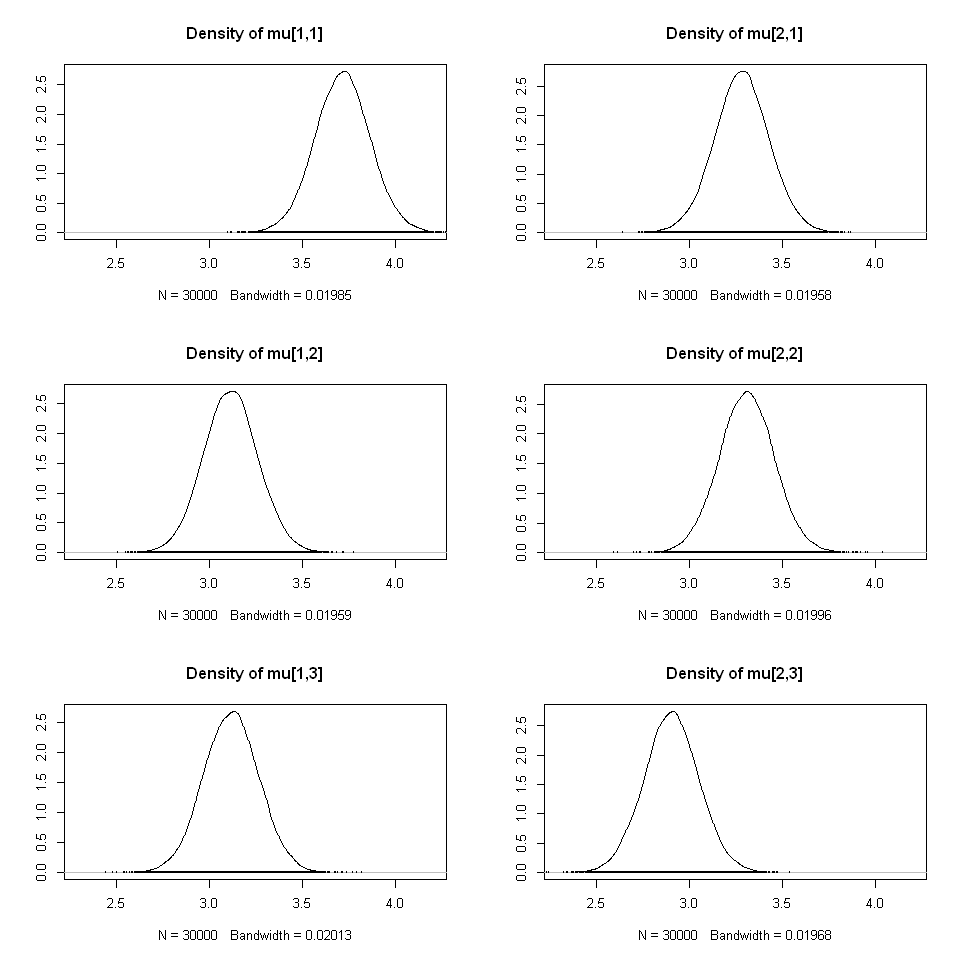

In [55]:
par(mfrow=c(3,2)) # arrange frame for plots
densplot(mod_3_csim[,1:6], xlim=c(2.3, 4.2))

It might be tempting to look at comparisons between each combination of treatments, but this could yield spurious results. It is best not to search your results for interesting hypotheses, because if there are many hypotheses, some will appear to show “effects” or “associations” simply due to chance. Results are most reliable when we determine a relatively small number of hypotheses we are interested in beforehand, collect the data, and statistically evaluate the evidence for them.

One question we might be interested in with these data is finding the treatment combination that produces the fewest breaks. To calculate this, we can go through our posterior samples and for each sample, find out which group has the smallest mean. These counts help us determine the posterior probability that each of the treatment groups has the smallest mean.

In [56]:
prop.table( table( apply(mod_3_csim[,1:6], 1, which.min) ) )


         2          3          4          5          6 
0.01526667 0.11776667 0.01033333 0.11710000 0.73953333 

In [57]:
# The evidence supports wool B with high tension as the treatment that produces the fewest breaks.

# Two-way cell means model with different Priors

In this new model, μ will be a matrix with six entries, each corresponding to a treatment group with each group having different variance.

In [73]:
mod_4_str = " model {
    # Actual Bayesian Model's Likelihood
    for(i in 1:length(y)){
        y[i] ~ dnorm(mu[woolGrp[i], tensGrp[i]], prec[woolGrp[i], tensGrp[i]])
    }

    # Priors
    for (j in 1:max(woolGrp)){
        for (k in 1:max(tensGrp)){
            mu[j, k] ~ dnorm(0.0, 1.0/1.0e6)
            prec[j, k] ~ dgamma(1.0/2.0, 1.0*1.0/2.0)
    }}
    

    # Variable dependent on Priors
    for (j in 1:max(woolGrp)){
        for (k in 1:max(tensGrp)){
            sig[j, k] = sqrt(1/prec[j, k])
    }}
} "

In [74]:
data_4_jags = list(y = log(warpbreaks$breaks), 
                   woolGrp = as.numeric(warpbreaks$wool), 
                   tensGrp = as.numeric(warpbreaks$tension))

In [75]:
params_4 = c("mu", "sig")

In [76]:
inits_4 = function(){
    inits = list(mu = matrix(rnorm(6, 1.0, 100.0), nrow = 2, byrow = TRUE),
                 prec = matrix(rgamma(6, 1.0/2, 1.0/2), nrow = 2, byrow = TRUE))
}

In [77]:
mod4 = jags.model(textConnection(mod_4_str), 
                  inits = inits_4, 
                  data = data_4_jags, 
                  n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 54
   Unobserved stochastic nodes: 12
   Total graph size: 193

Initializing model



### Simulations

In [78]:
update(mod4, 1e3)

In [79]:
mod_4_sim = coda.samples(model = mod4, 
                         variable.names = params_4, 
                         n.iter = 1e4)

In [80]:
mod_4_csim = as.mcmc(do.call(rbind, mod_4_sim))

### Model Checking

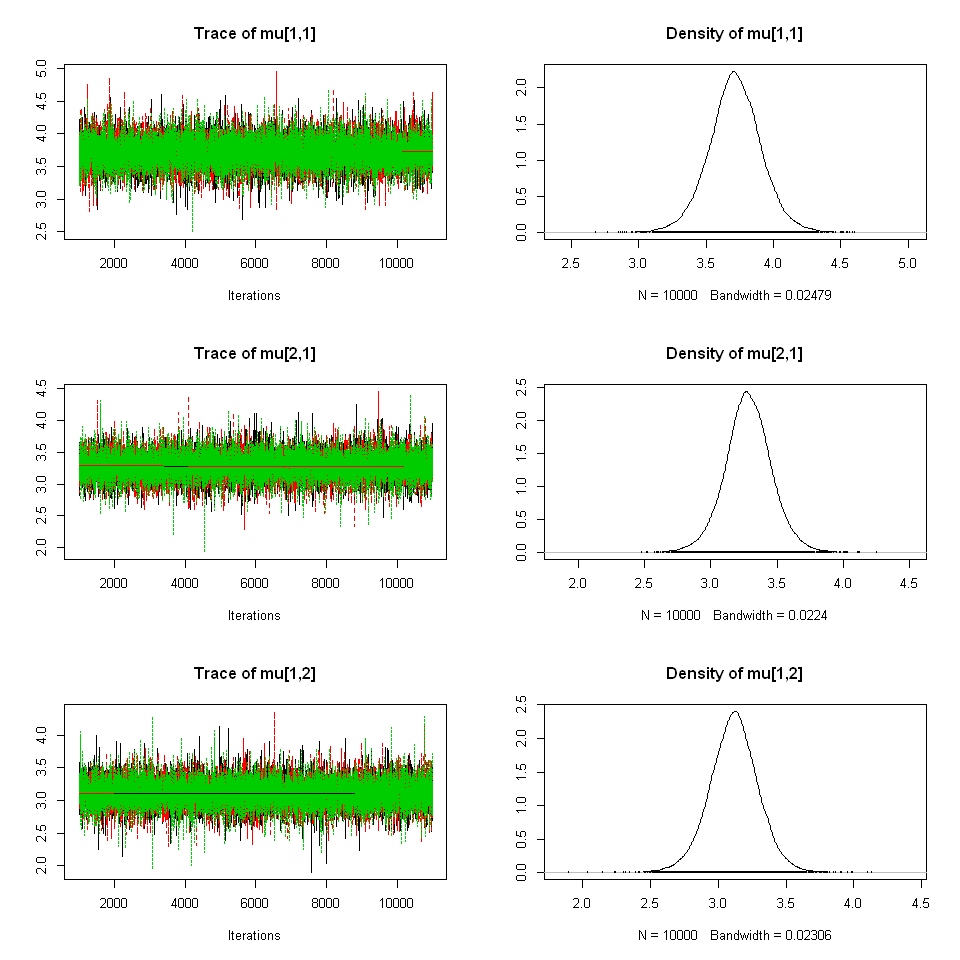

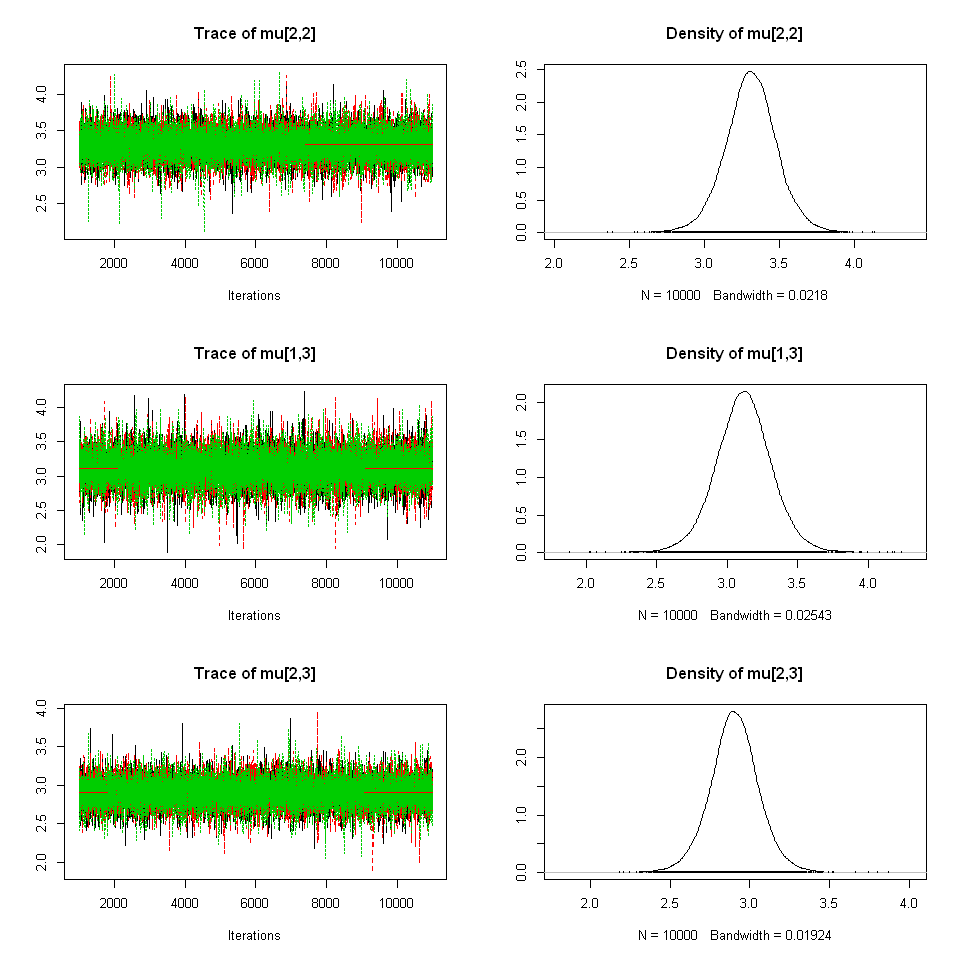

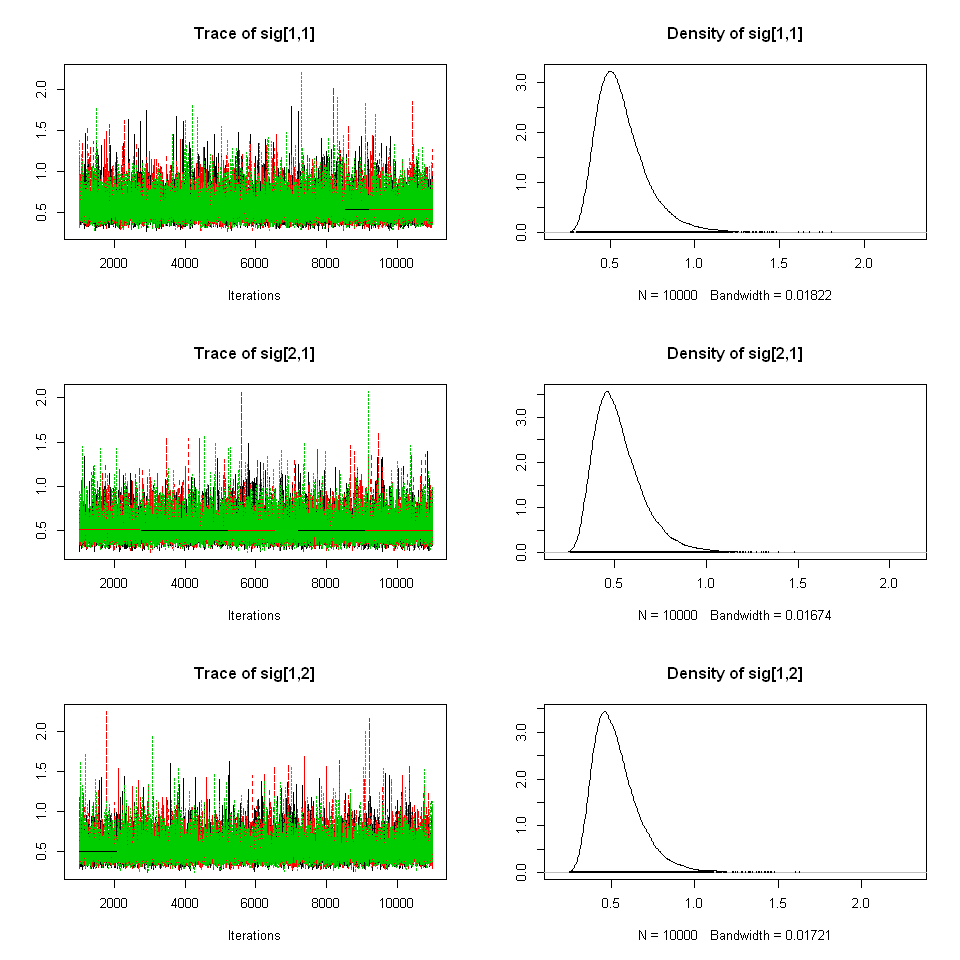

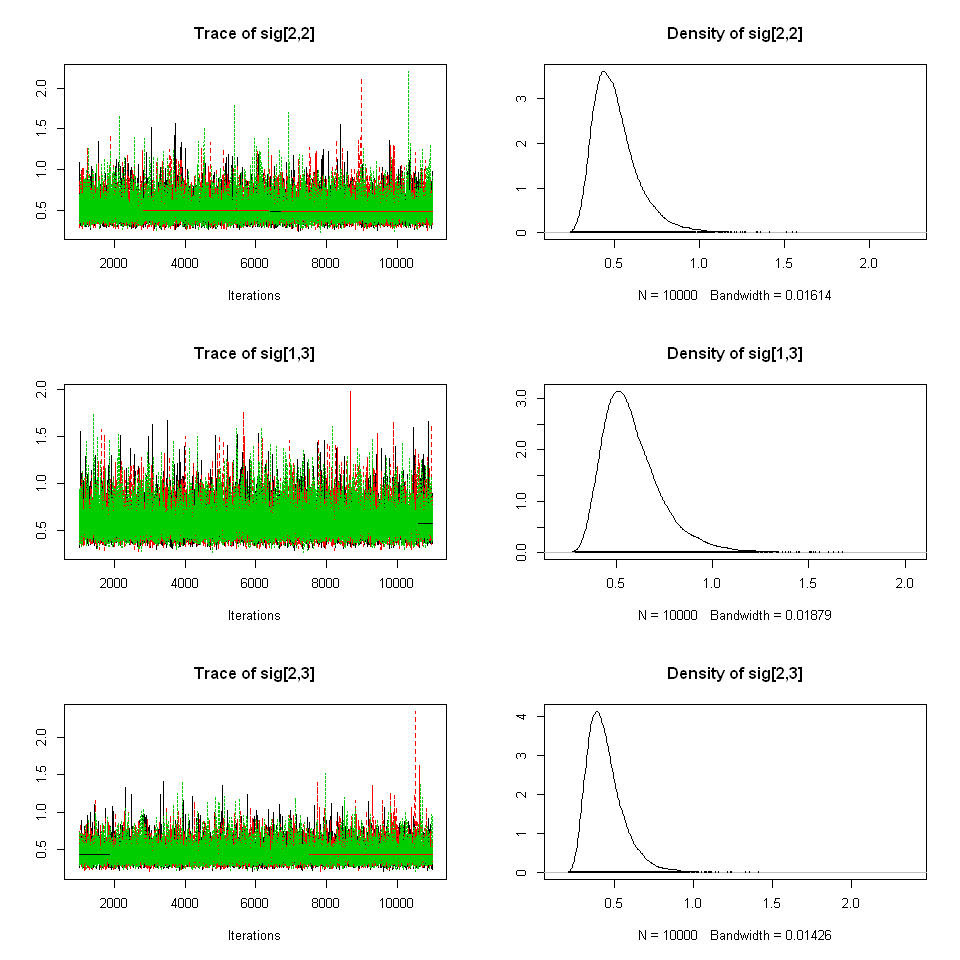

In [81]:
options(repr.plot.width=8, repr.plot.height=8)

plot(mod_4_sim)

In [82]:
gelman.diag(mod_4_sim)
autocorr.diag(mod_4_sim)
effectiveSize(mod_4_sim)
raftery.diag(mod_4_sim)

Potential scale reduction factors:

         Point est. Upper C.I.
mu[1,1]           1          1
mu[2,1]           1          1
mu[1,2]           1          1
mu[2,2]           1          1
mu[1,3]           1          1
mu[2,3]           1          1
sig[1,1]          1          1
sig[2,1]          1          1
sig[1,2]          1          1
sig[2,2]          1          1
sig[1,3]          1          1
sig[2,3]          1          1

Multivariate psrf

1

,"mu[1,1]","mu[2,1]","mu[1,2]","mu[2,2]","mu[1,3]","mu[2,3]","sig[1,1]","sig[2,1]","sig[1,2]","sig[2,2]","sig[1,3]","sig[2,3]"
Lag 0,1.000000000,1.0000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000e+00,1.000000000,1.000000000,1.000000000
Lag 1,-0.008805410,-0.0106456340,0.002716926,0.004108142,-0.011378181,0.001659944,0.126927330,0.129164358,1.284308e-01,0.123334313,0.122716210,0.123555490
Lag 5,-0.001118517,-0.0002616098,-0.004409565,-0.003148904,-0.002936585,-0.004882288,0.003013730,0.002152693,-9.087492e-05,-0.001236085,0.004292537,0.001876951
Lag 10,0.004227730,-0.0034888089,-0.012606702,0.002282738,0.006964460,0.007071533,0.008039187,0.001548715,-5.594529e-03,0.006206247,-0.009207042,-0.008622758
Lag 50,0.002992877,-0.0028521700,0.003488759,0.001275547,-0.005315752,0.000970196,-0.006861851,0.003998687,1.108816e-02,-0.001920583,0.007973096,-0.005236050


mu[1,1]  mu[2,1]  mu[1,2]  mu[2,2]  mu[1,3]  mu[2,3] sig[1,1] sig[2,1] 
30390.31 30641.49 30000.00 29919.11 30245.44 30080.85 23177.52 23837.55 
sig[1,2] sig[2,2] sig[1,3] sig[2,3] 
23493.38 23410.38 23787.52 23171.55

[[1]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                                
          Burn-in  Total Lower bound  Dependence
          (M)      (N)   (Nmin)       factor (I)
 mu[1,1]  2        3897  3746         1.040     
 mu[2,1]  2        3865  3746         1.030     
 mu[1,2]  3        4061  3746         1.080     
 mu[2,2]  2        3997  3746         1.070     
 mu[1,3]  3        4095  3746         1.090     
 mu[2,3]  2        3834  3746         1.020     
 sig[1,1] 2        3771  3746         1.010     
 sig[2,1] 2        3929  3746         1.050     
 sig[1,2] 2        3865  3746         1.030     
 sig[2,2] 2        3802  3746         1.010     
 sig[1,3] 2        3929  3746         1.050     
 sig[2,3] 2        3741  3746         0.999     


[[2]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                                
          Burn-in  Total Lower bound  Dependence
          (

### Result

In [83]:
dic_4 = dic.samples(model = mod3, n.iter = 1e4)
dic_4

Mean deviance:  52.06 
penalty 7.195 
Penalized deviance: 59.26 

In [84]:
dic_3

Mean deviance:  52.01 
penalty 7.227 
Penalized deviance: 59.23 

In [86]:
dic_2

Mean deviance:  55.5 
penalty 5.11 
Penalized deviance: 60.61 

In [87]:
dic_1

Mean deviance:  58.47 
penalty 4.015 
Penalized deviance: 62.48 

In [85]:
HPDinterval(mod_4_csim, prob = 0.95)

,lower,upper
"mu[1,1]",3.3261878,4.1202027
"mu[2,1]",2.9242161,3.6484676
"mu[1,2]",2.7526336,3.4836383
"mu[2,2]",2.9673828,3.6658755
"mu[1,3]",2.7109151,3.5181238
"mu[2,3]",2.5851382,3.2081232
"sig[1,1]",0.3291012,0.8831598
"sig[2,1]",0.3031348,0.7988731
"sig[1,2]",0.3020678,0.8136045
"sig[2,2]",0.2842935,0.7738337
